# Figure 3g

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from requirements import *
from segger.data.parquet._utils import (
    filter_transcripts,
    load_settings,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import preprocess_rapids
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.tl.get_group_markers import *
from sg_utils.pl.plot_group_markers import plot_group_markers

## Cell Type Markers by Compartment

In [4]:
# Read in AnnData
ad = sc.read_h5ad(data_dir / 'h5ads/core_nsclc_atlas_panel_only.h5ad')

# Add cell compartment labels to AnnData
filename = 'core_nsclc_atlas_cell_type_labels.csv'
cell_type_labels = pd.read_csv(data_dir / filename, index_col=0)['0']
ad.obs['cell_compartment'] = ad.obs['cell_type'].map(cell_type_labels)

# Subset to Xenium panel genes
panel = pd.read_csv(data_dir / 'gene_information.csv', index_col='gene')
mask = ad.var.index.isin(panel.index)
ad = ad[:, mask].copy()

# Get markers by cell compartment
ad.X = ad.layers['count']
get_group_markers(ad, 'cell_compartment', max_residual=0.5, n_pts=10)
ad.write_h5ad(data_dir / 'h5ads/core_nsclc_atlas_panel_only.h5ad')

In [6]:
# Genes to highlight
highlight = {
    named_colors['Epithelial']: ['EPCAM', 'KRT8', 'CHGA', 'SOX2', 'SFTPB'],
    named_colors['Fibroblast and Stromal']: ['FN1', 'COL5A2', 'COL8A1'],
    named_colors['Myeloid']: ['CD163', 'CD1A'],
    named_colors['Lymphoid']: ['CD3E', 'CD3D', 'CD8A'],
}
highlight = {v: k for k, vals in highlight.items() for v in vals}

/lilac/data/peer/moormana/GitHub/dpeerlab/segger_dev/manuscript/src/sg_utils/tl/get_group_markers.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ad.var[column] = ad.var[column].fillna(False).astype(bool)


Text(-22.33272135416667, 0.5, 'Log Mean Transcripts (Epithelial)')

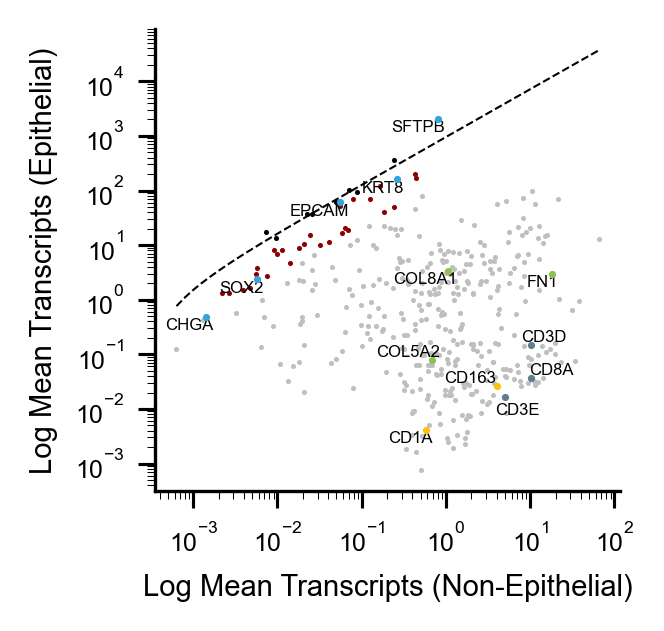

In [8]:
fig, ax = plt.subplots(1,1, figsize=(2,2))

plot_group_markers(
    ad,
    groupby='cell_compartment',
    name='Epithelial/Cancer',
    max_residual=0.75,
    n_pts=10,
    highlight=highlight,
    ax=ax,
)

ax.set_xlabel('Log Mean Transcripts (Non-Epithelial)', fontsize=7) 
ax.set_ylabel('Log Mean Transcripts (Epithelial)', fontsize=7) 

## Transcripts to AnnData

*Note*: Below, I filter using 'min_counts_per_cell' = 50. 
This is fairly aggressive for Xenium data, as it removes, for instance, many 
immune cells which have lower capture levels. However, for this analysis, my
primary concern is capturing genuine epithelial cells, whose UMIs are high above
this level, and a more aggressive filtering significantly cleans the data.

In [177]:
# Read in all transcripts
transcripts = pd.read_parquet(data_dir / 'labeled_transcripts.parquet')

# Filter control probes and low QV probes
xe_settings = load_settings('xenium')

transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=30,
)

In [194]:
# Build and process AnnData for cellpose
seg_col = 'cellpose_cell_id'

# Transcripts to anndata
ad = anndata_from_transcripts(
    transcripts,
    cell_label=seg_col,
    gene_label='feature_name',
)
# Preprocess
preprocess_rapids(
    ad,
    filter_min_counts=40,
    pca_total_var=0.75,
    pca_layer='norm',
    knn_neighbors=20,
    phenograph_resolution=1.5,
)
# Save to file
ad.write_h5ad(data_dir / f'{seg_col}.h5ad')

Clustering:  83%|████████▎ | 5/6 [00:45<00:14, 14.45s/it]   

[I] [01:30:04.562247] Transform can only be run with brute force. Using brute force.


Done: 100%|██████████| 6/6 [01:03<00:00, 10.57s/it]      


## Cell Type by Cluster

In [9]:
# Read in CellPose AnnData
seg_col = 'cellpose_cell_id'
ad = sc.read_h5ad(data_dir / f'{seg_col}.h5ad')

# Transfer columns from NSCLC atlas ref to CellPose Anndata
ad_ref = sc.read_h5ad(data_dir / 'h5ads/core_nsclc_atlas_panel_only.h5ad')
ad_ref.var.drop('cell_compartment_marker', inplace=True, axis=1)
columns = ad_ref.var.columns[ad_ref.var.columns.str.contains(' Marker')]
ad.var[columns] = ad_ref.var[columns]
ad.var[columns] = ad.var[columns].fillna(False).astype(bool)

# Cell type by cluster
ad.layers['z-score'] = sp.stats.zscore(ad.layers['lognorm'].todense().A)
ad.X = ad.layers['z-score']
names = []
for col in columns:
    genes = ad.var.index[ad.var[col]]
    score_name = col.replace(' Marker', ' Score')
    sc.tl.score_genes(ad, genes, score_name=score_name, use_raw=False)
    names.append(score_name)

cell_types = ad.obs.groupby('phenograph_cluster')[names].mean()
cell_types = cell_types.idxmax(1)
cell_types = cell_types.str.replace(' Score', '')
ad.obs['cell_type'] = ad.obs['phenograph_cluster'].map(cell_types)

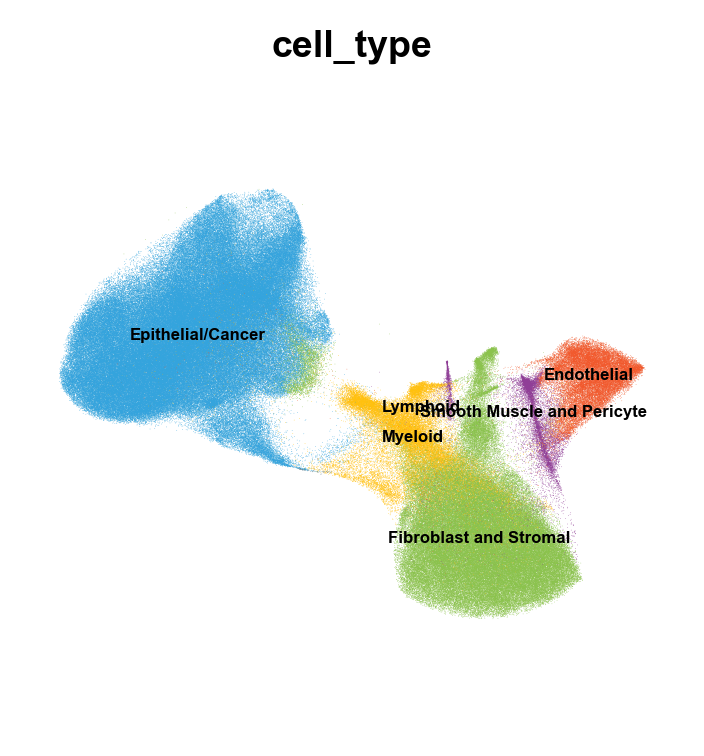

In [10]:
fig = plot_embedding(
    ad,
    'cell_type',
    basis='X_umap',
    legend_loc='on data',
    palette=named_colors,
    legend_fontsize=4,
    dim=3,
    s=0.1,
)

In [11]:
# Write back to file
ad.write_h5ad(data_dir / f'{seg_col}.h5ad')

## Other

In [212]:
# Read in CellPose AnnData
seg_col = 'cellpose_cell_id'
ad = sc.read_h5ad(data_dir / f'{seg_col}.h5ad')

# Transfer columns from NSCLC atlas ref to CellPose Anndata
panel = pd.read_csv(data_dir / 'gene_information.csv', index_col='gene')

# Cell type by cluster
ad.layers['z-score'] = sp.stats.zscore(ad.layers['lognorm'].todense().A)
ad.X = ad.layers['z-score']
names = []
for name, group in panel.groupby('compartment_Annotation'):
    genes = group.index
    score_name = name + '_score'
    sc.tl.score_genes(ad, genes, score_name=score_name, use_raw=False)
    names.append(score_name)

cell_types = ad.obs.groupby('phenograph_cluster')[names].mean()
cell_types = cell_types.idxmax(1)
cell_types = cell_types.str.replace('_score', '').str.replace('_', ' ')
ad.obs['cell_type'] = ad.obs['phenograph_cluster'].map(cell_types)

In [17]:
# 1) Map cellpose ids to 10x nucleus ids based on the most frequent nucleus id
#    found in each cell
# 2) Map epithelial labels from 10x nucleus AnnData to transcripts
src_id = 'cellpose_cell_id'
dst_id = '10x_nucleus_id'
labels = ad.obs['is_epithelial']

df = cudf.from_pandas(transcripts[[src_id, dst_id]])
counts = df.value_counts()
src_to_dst = counts.index[counts.groupby(src_id).idxmax().values]
src_to_dst = cudf.Series(
    src_to_dst.get_level_values(1),
    src_to_dst.get_level_values(0),
)
src_labels = src_to_dst.map(cudf.from_pandas(labels))
transcripts['is_epithelial'] = df[src_id].map(src_labels).to_pandas()

In [146]:



# Get cell type fractions per cell
ad.layers['z-score'] = sp.stats.zscore(ad.layers['norm'].todense().A)
fractions = pd.DataFrame(index=ad.obs.index, columns=columns)
for col in columns:
    genes = ad.var.index[ad.var[col].fillna(False)]
    fractions[col] = ad[:, genes].layers['z-score'].sum(1).flatten()

fractions = fractions.divide(fractions.sum(axis=1), axis=0)
fractions.columns = fractions.columns.str.replace('marker', 'fraction')
ad.obs[fractions.columns] = fractions


# Get epithelial clusters
by_cluster = ad.obs.groupby('phenograph_cluster')[fractions.columns].mean()
is_epi = by_cluster['epithelial/cancer_fraction'] > 0.5
ad.obs['is_epithelial'] = ad.obs['phenograph_cluster'].map(is_epi)